In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the dataset directory
original_dataset_dir = r"C:\Users\Priyamvadha Pradeep\Desktop\DL Mid Model\horse-or-human"
base_dir = r'C:\Users\Priyamvadha Pradeep\Desktop\DL Mid Model\processed_data'

# Create directories for training and testing
train_horses_dir = os.path.join(base_dir, 'train', 'horses')
train_humans_dir = os.path.join(base_dir, 'train', 'humans')
test_horses_dir = os.path.join(base_dir, 'test', 'horses')
test_humans_dir = os.path.join(base_dir, 'test', 'humans')

# Create directories
for directory in [train_horses_dir, train_humans_dir, test_horses_dir, test_humans_dir]:
    os.makedirs(directory, exist_ok=True)

# Load images and split dataset
images = []
labels = []
for category in ['horses', 'humans']:
    category_path = os.path.join(original_dataset_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(0 if category == 'horses' else 1)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the number of images in each set
print(f'Train horses: {np.sum(y_train == 0)}')
print(f'Train humans: {np.sum(y_train == 1)}')
print(f'Test horses: {np.sum(y_test == 0)}')
print(f'Test humans: {np.sum(y_test == 1)}')

Train horses: 397
Train humans: 424
Test horses: 103
Test humans: 103


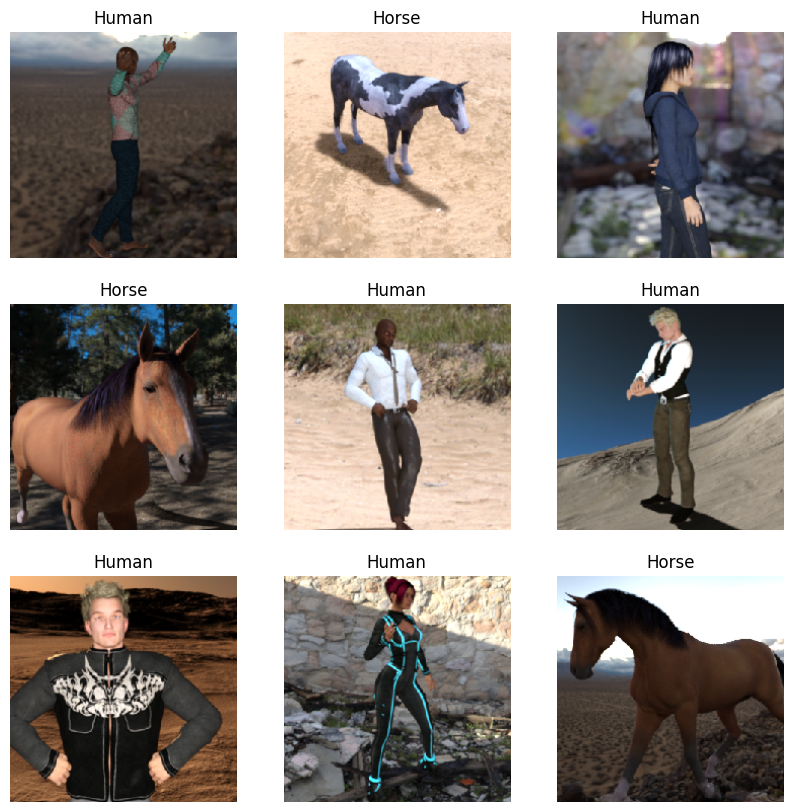

In [2]:
# Visualize some samples from the dataset
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title('Horse' if y_train[i] == 0 else 'Human')
    plt.axis('off')
plt.show()

In [3]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model_vgg16(learning_rate=0.001):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, activation='softmax')  # Two classes: horses and humans
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def create_model_resnet50(learning_rate=0.001):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, activation='softmax')  # Two classes: horses and humans
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [4]:
# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, validation_split=0.2)

# Create flow from directory for training and validation
train_generator = datagen.flow(X_train, y_train, subset='training')
val_generator = datagen.flow(X_train, y_train, subset='validation')

# Set hyperparameters
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]

results = {}

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        print(f'Training VGG16 with learning rate: {learning_rate}, batch size: {batch_size}')
        model_vgg = create_model_vgg16(learning_rate=learning_rate)
        
        history_vgg = model_vgg.fit(train_generator, 
                                    validation_data=val_generator, 
                                    epochs=10, 
                                    batch_size=batch_size,
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])
        
        # Evaluate the model
        test_loss, test_accuracy = model_vgg.evaluate(X_test, y_test)
        results[(learning_rate, batch_size, 'VGG16')] = (test_loss, test_accuracy)

        print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

        print(f'Training ResNet50 with learning rate: {learning_rate}, batch size: {batch_size}')
        model_resnet = create_model_resnet50(learning_rate=learning_rate)
        
        history_resnet = model_resnet.fit(train_generator, 
                                           validation_data=val_generator, 
                                           epochs=10, 
                                           batch_size=batch_size,
                                           callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])
        
        # Evaluate the model
        test_loss, test_accuracy = model_resnet.evaluate(X_test, y_test)
        results[(learning_rate, batch_size, 'ResNet50')] = (test_loss, test_accuracy)

        print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Training VGG16 with learning rate: 0.001, batch size: 32
Epoch 1/10


c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.5489 - loss: 4.4235 - val_accuracy: 0.9268 - val_loss: 0.1482
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9351 - loss: 0.1422 - val_accuracy: 0.9512 - val_loss: 0.0963
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9924 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0156
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9998 - loss: 0.0155 - val_accuracy: 0.9878 - val_loss: 0.0221
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0049
Epo

Model: VGG16, Learning Rate: 0.001, Batch Size: 32, Loss: 0.0008709285757504404, Accuracy: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step


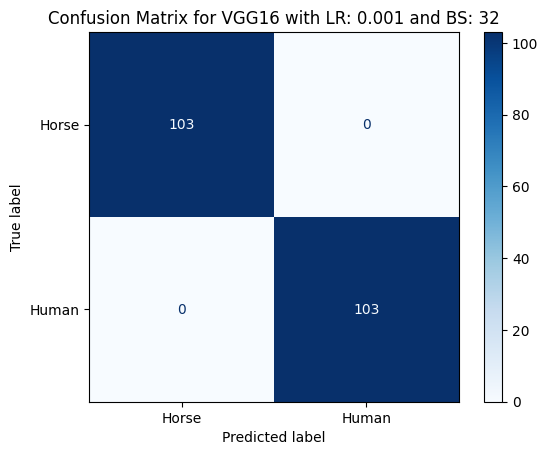

Model: ResNet50, Learning Rate: 0.001, Batch Size: 32, Loss: 0.2798757553100586, Accuracy: 0.8883495330810547
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step


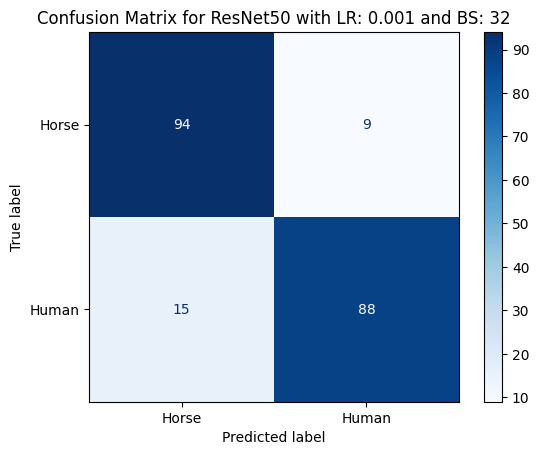

Model: VGG16, Learning Rate: 0.001, Batch Size: 64, Loss: 0.012991534546017647, Accuracy: 0.9902912378311157
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step


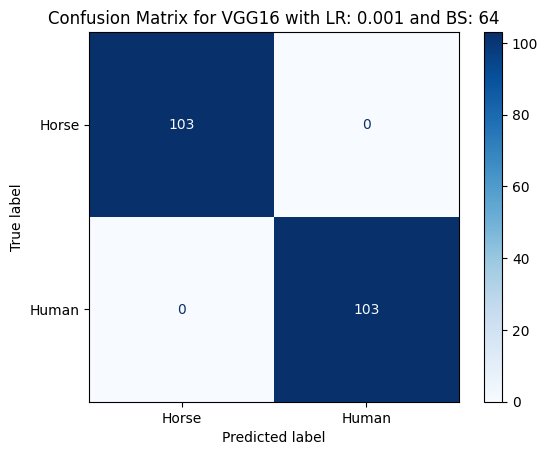

Model: ResNet50, Learning Rate: 0.001, Batch Size: 64, Loss: 0.22768698632717133, Accuracy: 0.8786407709121704
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


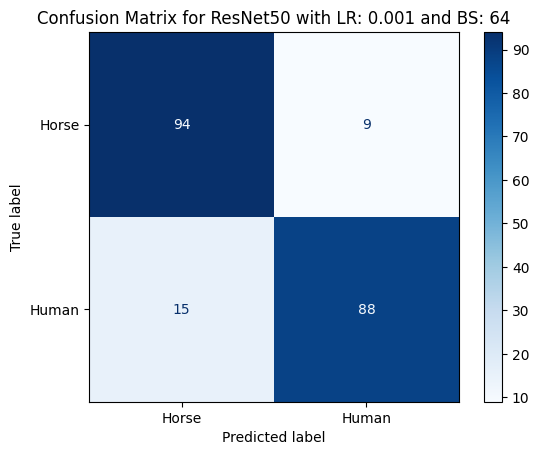

Model: VGG16, Learning Rate: 0.0001, Batch Size: 32, Loss: 0.002597703831270337, Accuracy: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step


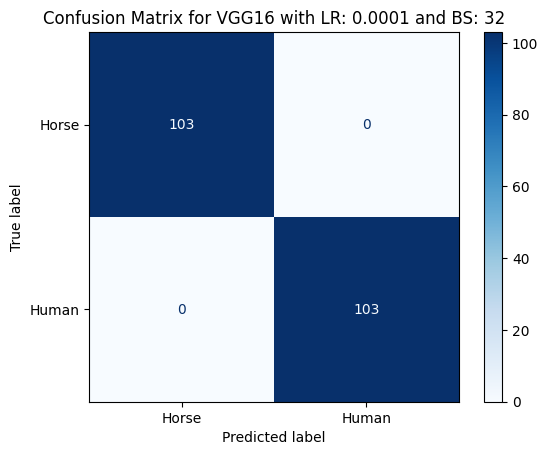

Model: ResNet50, Learning Rate: 0.0001, Batch Size: 32, Loss: 0.16983802616596222, Accuracy: 0.9417475461959839
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


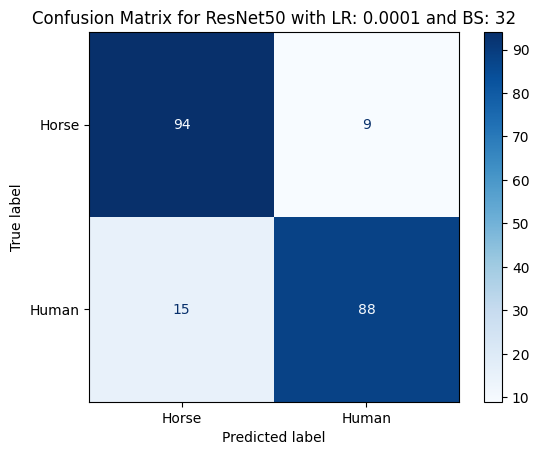

Model: VGG16, Learning Rate: 0.0001, Batch Size: 64, Loss: 0.003788547357544303, Accuracy: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step


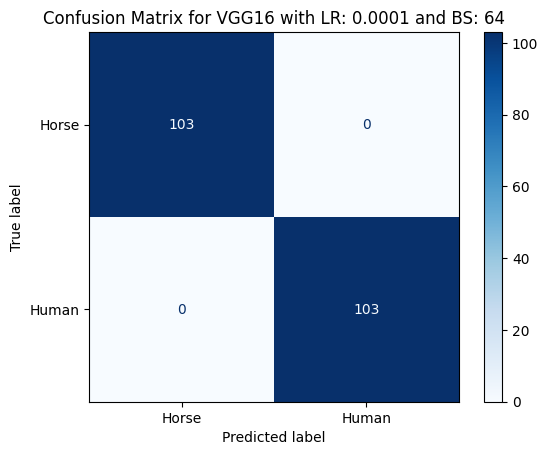

Model: ResNet50, Learning Rate: 0.0001, Batch Size: 64, Loss: 0.25679516792297363, Accuracy: 0.8834951519966125
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


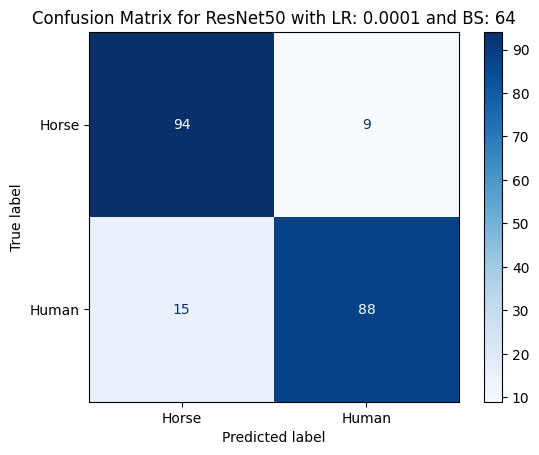

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have predictions
for key, (loss, accuracy) in results.items():
    lr, bs, model_name = key
    print(f'Model: {model_name}, Learning Rate: {lr}, Batch Size: {bs}, Loss: {loss}, Accuracy: {accuracy}')
    
    # Make predictions
    y_pred = model_vgg.predict(X_test) if model_name == 'VGG16' else model_resnet.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Horse', 'Human'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name} with LR: {lr} and BS: {bs}')
    plt.show()